In [1]:
import pyspark
from pyspark.sql import SparkSession
import mysql.connector
import re

In [2]:
from pyspark.sql.functions import regexp_replace

In [3]:
spark = SparkSession\
    .builder\
    .appName("capstone_analysis")\
    .config("spark.jars","/opt/homebrew/Cellar/apache-spark/3.3.1/libexec/jars/mysql-connector-j-8.0.32.jar")\
    .getOrCreate()

23/02/21 09:35:08 WARN Utils: Your hostname, Sules-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.17 instead (on interface en0)
23/02/21 09:35:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/02/21 09:35:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# read the tables
table_names = {'credit_transformed':'CDW_SAPP_CREDIT_CARD',
               'branch_transformed':'CDW_SAPP_BRANCH',
               'customer_transformed':'CDW_SAPP_CUSTOMER',
               'loan_transformed':'CDW_SAPP_loan_application'}

In [4]:
# read tables

credit = spark.read \
    .jdbc("jdbc:mysql://localhost:3306/creditcard_capstone","CDW_SAPP_CREDIT_CARD", \
          properties={"user": "root", "driver":"com.mysql.cj.jdbc.Driver"})
credit.createTempView("credit_tb")
credit.show(3)

+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|      CUST_CC_NO|  TIMEID| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|4210653349028689|20180214|123459988|        114|       Education|             78.9|             1|
|4210653312478046|20180813|123455692|        156|         Grocery|            91.08|         22562|
|4210653342242023|20180315|123451310|        180|           Bills|            77.79|         45069|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+
only showing top 3 rows



In [5]:
branch = spark.read \
    .jdbc("jdbc:mysql://localhost:3306/creditcard_capstone","CDW_SAPP_BRANCH", \
          properties={"user": "root", "driver":"com.mysql.cj.jdbc.Driver"})
branch.createTempView("branch_tb")
branch.show(3)

+-----------+------------+-----------------+-----------------+------------+----------+-------------+-------------------+
|BRANCH_CODE| BRANCH_NAME|    BRANCH_STREET|      BRANCH_CITY|BRANCH_STATE|BRANCH_ZIP| BRANCH_PHONE|       LAST_UPDATED|
+-----------+------------+-----------------+-----------------+------------+----------+-------------+-------------------+
|          1|Example Bank|     Bridle Court|        Lakeville|          MN|     55044|(123)456-5276|2018-04-18 16:51:47|
|          2|Example Bank|Washington Street|          Huntley|          IL|     60142|(123)461-8993|2018-04-18 16:51:47|
|          3|Example Bank|    Warren Street|SouthRichmondHill|          NY|     11419|(123)498-5926|2018-04-18 16:51:47|
+-----------+------------+-----------------+-----------------+------------+----------+-------------+-------------------+
only showing top 3 rows



In [6]:
customer = spark.read \
    .jdbc("jdbc:mysql://localhost:3306/creditcard_capstone","CDW_SAPP_CUSTOMER", \
          properties={"user": "root", "driver":"com.mysql.cj.jdbc.Driver"})
customer.createTempView("customer_tb")
customer.show(3)

+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+-------------+-------------------+-------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  CREDIT_CARD_NO| FULL_STREET_ADDRESS|   CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|   CUST_PHONE|         CUST_EMAIL|       LAST_UPDATED|
+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+-------------+-------------------+-------------------+
|123456100|      Alec|         wm|   Hooper|4210653310061055|Main Street North...|     Natchez|        MS|United States|   39120|(111)111-1111|AHooper@example.com|2018-04-21 12:49:02|
|123453023|      Etta|    brendan|   Holman|4210653310102868|  Redwood Drive, 829|Wethersfield|        CT|United States|    6109|(111)123-8933|EHolman@example.com|2018-04-21 12:49:02|
|123454487|    Wilber|   ezequiel|   Dunham|4210653310116272|12th Street East,..

In [18]:
customer.printSchema()

root
 |-- SSN: integer (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- FULL_STREET_ADDRESS: string (nullable = true)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_ZIP: integer (nullable = true)
 |-- CUST_PHONE: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- LAST_UPDATED: timestamp (nullable = true)



### REQ-2.1: Transaction Details 
1)    Used to display the transactions made by customers living in a given zip code for a given month and year. Order by day in descending order.
2)    Used to display the number and total values of transactions for a given type.
3)    Used to display the number and total values of transactions for branches in a given state.

In [36]:
# get inputs (write input function with argparse)
zipcode = 39120
month = str(2)
year = str(2018)
date_string = year+month.zfill(2)
date_string

'201802'

In [54]:
q = "SELECT credit_tb.TRANSACTION_TYPE, "\
    "credit_tb.TRANSACTION_VALUE, "\
    "credit_tb.TRANSACTION_ID, "\
    "credit_tb.TIMEID, "\
    "customer_tb.CUST_ZIP "\
    "FROM credit_tb " \
    "JOIN customer_tb " \
    "ON credit_tb.CUST_SSN = customer_tb.SSN "\
    f"WHERE customer_tb.CUST_ZIP = {zipcode} "\
    f"AND credit_tb.TIMEID LIKE '{date_string}%' "\
    "ORDER BY TIMEID ASC;"

spark.sql(q).show()

+----------------+-----------------+--------------+--------+--------+
|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|  TIMEID|CUST_ZIP|
+----------------+-----------------+--------------+--------+--------+
|             Gas|            89.75|         22989|20180201|   39120|
|            Test|            55.19|          2211|20180201|   39120|
|             Gas|            40.91|          3530|20180202|   39120|
|       Education|            28.96|         15206|20180203|   39120|
|            Test|            38.85|          3548|20180204|   39120|
|      Healthcare|             38.4|          3549|20180205|   39120|
|       Education|            58.35|         12643|20180206|   39120|
|      Healthcare|            25.24|          2196|20180206|   39120|
|       Education|            17.88|          2216|20180207|   39120|
|      Healthcare|            46.21|         20550|20180208|   39120|
|           Bills|            22.17|         15267|20180209|   39120|
|            Test|  

In [55]:
#2. given transaction types:
spark.sql("SELECT DISTINCT(TRANSACTION_TYPE) FROM credit_tb;").show()

+----------------+
|TRANSACTION_TYPE|
+----------------+
|       Education|
|   Entertainment|
|      Healthcare|
|         Grocery|
|            Test|
|             Gas|
|           Bills|
+----------------+



In [60]:
trans_type = "Education"
spark.sql(f"SELECT TRANSACTION_TYPE, SUM(TRANSACTION_VALUE) FROM credit_tb GROUP BY TRANSACTION_TYPE HAVING TRANSACTION_TYPE = '{trans_type}';").show()

+----------------+----------------------+
|TRANSACTION_TYPE|sum(TRANSACTION_VALUE)|
+----------------+----------------------+
|       Education|    337980.07000000146|
+----------------+----------------------+



In [62]:
spark.sql("SELECT DISTINCT(BRANCH_STATE) FROM branch_tb;").show()


+------------+
|BRANCH_STATE|
+------------+
|          SC|
|          MN|
|          NJ|
|          VA|
|          KY|
|          MI|
|          WI|
|          CA|
|          CT|
|          MT|
|          NC|
|          MD|
|          IL|
|          WA|
|          MS|
|          AL|
|          IN|
|          OH|
|          IA|
|          PA|
+------------+
only showing top 20 rows



In [69]:
state = 'WI'
q = "SELECT branch_tb.BRANCH_STATE, "\
    "COUNT(TRANSACTION_ID), "\
    "SUM(TRANSACTION_VALUE) "\
    "from credit_tb JOIN branch_tb ON credit_tb.BRANCH_CODE = branch_tb.BRANCH_CODE "\
    f"WHERE branch_tb.BRANCH_STATE = '{state}'"\
    "GROUP BY branch_tb.BRANCH_STATE;"
spark.sql(q).show()

+------------+---------------------+----------------------+
|BRANCH_STATE|count(TRANSACTION_ID)|sum(TRANSACTION_VALUE)|
+------------+---------------------+----------------------+
|          WI|                 1677|     85899.84000000005|
+------------+---------------------+----------------------+



### REQ-2.2: Customer Details Module
1) Used to check the existing account details of a customer. (hide part of ssn)
2) Used to modify the existing account details of a customer.
3) Used to generate a monthly bill for a credit card number for a given month and year.
4) Used to display the transactions made by a customer between two dates. Order by year, month, and day in descending order.


In [84]:
cut_name = "Alec wm Hooper\n".strip("\n").split()
first = cut_name[0].title()
middle = cut_name[1].lower()
last = cut_name[2].title()
print(first, middle, last)
q = f"SELECT * FROM customer_tb WHERE FIRST_NAME='{first}' AND MIDDLE_NAME='{middle}' AND LAST_NAME='{last}'" 
dfnew  = spark.sql(q)
dfnew = dfnew.withColumn("SSN_masked", regexp_replace(dfnew['SSN'],r"(\d{5})(\d{4})", "*****$2"))
dfnew.select('SSN_masked','FIRST_NAME', 'MIDDLE_NAME', 'LAST_NAME', 
                       'CREDIT_CARD_NO', 'FULL_STREET_ADDRESS', 'CUST_CITY',
                        'CUST_STATE', 'CUST_COUNTRY', 'CUST_ZIP', 'CUST_PHONE', 
                        'CUST_EMAIL', 'LAST_UPDATED').show()

Alec wm Hooper
+----------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+-------------+-------------------+-------------------+
|SSN_masked|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  CREDIT_CARD_NO| FULL_STREET_ADDRESS|CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|   CUST_PHONE|         CUST_EMAIL|       LAST_UPDATED|
+----------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+-------------+-------------------+-------------------+
| *****6100|      Alec|         wm|   Hooper|4210653310061055|Main Street North...|  Natchez|        MS|United States|   39120|(111)123-7818|AHooper@example.com|2018-04-21 12:49:02|
+----------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+-------------+-------------------+-------------------+



In [143]:
# update table are not available error for the below expression (UPDATE TABLE is not supported temporarily)
spark.sql("UPDATE customer_tb  SET LAST_UPDATED = CURRENT_TIMESTAMP() WHERE FIRST_NAME='Alec'")


Py4JJavaError: An error occurred while calling o27.sql.
: java.lang.UnsupportedOperationException: UPDATE TABLE is not supported temporarily.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.ddlUnsupportedTemporarilyError(QueryExecutionErrors.scala:909)
	at org.apache.spark.sql.execution.SparkStrategies$BasicOperators$.apply(SparkStrategies.scala:819)
	at org.apache.spark.sql.catalyst.planning.QueryPlanner.$anonfun$plan$1(QueryPlanner.scala:63)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at org.apache.spark.sql.catalyst.planning.QueryPlanner.plan(QueryPlanner.scala:93)
	at org.apache.spark.sql.execution.SparkStrategies.plan(SparkStrategies.scala:69)
	at org.apache.spark.sql.catalyst.planning.QueryPlanner.$anonfun$plan$3(QueryPlanner.scala:78)
	at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:196)
	at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:194)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at org.apache.spark.sql.catalyst.planning.QueryPlanner.$anonfun$plan$2(QueryPlanner.scala:75)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at org.apache.spark.sql.catalyst.planning.QueryPlanner.plan(QueryPlanner.scala:93)
	at org.apache.spark.sql.execution.SparkStrategies.plan(SparkStrategies.scala:69)
	at org.apache.spark.sql.execution.QueryExecution$.createSparkPlan(QueryExecution.scala:459)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$sparkPlan$1(QueryExecution.scala:145)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:111)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:185)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:510)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:185)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:184)
	at org.apache.spark.sql.execution.QueryExecution.sparkPlan$lzycompute(QueryExecution.scala:145)
	at org.apache.spark.sql.execution.QueryExecution.sparkPlan(QueryExecution.scala:138)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executedPlan$1(QueryExecution.scala:158)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:111)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:185)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:510)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:185)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:184)
	at org.apache.spark.sql.execution.QueryExecution.executedPlan$lzycompute(QueryExecution.scala:158)
	at org.apache.spark.sql.execution.QueryExecution.executedPlan(QueryExecution.scala:151)
	at org.apache.spark.sql.execution.QueryExecution.simpleString(QueryExecution.scala:204)
	at org.apache.spark.sql.execution.QueryExecution.org$apache$spark$sql$execution$QueryExecution$$explainString(QueryExecution.scala:249)
	at org.apache.spark.sql.execution.QueryExecution.explainString(QueryExecution.scala:218)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:176)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:560)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.Dataset.<init>(Dataset.scala:220)
	at org.apache.spark.sql.Dataset$.$anonfun$ofRows$2(Dataset.scala:100)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:97)
	at org.apache.spark.sql.SparkSession.$anonfun$sql$1(SparkSession.scala:622)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.SparkSession.sql(SparkSession.scala:617)
	at java.base/jdk.internal.reflect.DirectMethodHandleAccessor.invoke(DirectMethodHandleAccessor.java:104)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1589)


In [177]:
# modify account details: (write out to the db, update last updated with timestamp now())
# read new info
# update table 
#save df to database
# Please enter item numbers to be modified:

def modify_customer_record():
    string1="""Please choose a number 1 to 5 to update one of the following:
    1 |-- NAME
    2 |-- CREDIT_CARD_NO
    3 |-- ADRESS
    4 |-- CUST_PHONE
    5 |-- CUST_EMAIL
    """
    choice = int(input(string1))
    if choice not in range(1,6):
        print('You entered a wrong choice!')
        choice = int(input(string1))

    ssn = input("Please enter the SSN for the record you wish to update").strip()
    if choice == 1:
        new_first = input("Enter new first name:").strip().title()
        new_middle = input("Enter new middle name:").strip().lower()
        new_last = input("Enter new last name:").strip().title()
        changes = f"UPDATE customer_tb SET FIRST_NAME = '{new_first}', "\
            f"MIDDLE_NAME = '{new_middle}', "\
            f"LAST_NAME = '{new_last}' "    

    elif choice == 2:
        new_card = input("Enter 16-digit new credit card number:").strip()
        changes = f"UPDATE customer_tb SET CREDIT_CARD_NO = '{new_card}'"

    elif choice == 3:
        new_add = input("""Enter street name, street number, 
        city, state, country, zipcode as a comma separated list""").strip().split(',')
        changes = f"UPDATE customer_tb SET FULL_STREET_ADRESS = '{new_add[0]}, {new_add[1]}', "\
            f"CUST_CITY = '{new_add[2]}', "\
            f"CUST_STATE = '{new_add[3]}', "\
            f"CUST_COUNTRY = '{new_add[4]}', "\
            f"ZIP_CODE = '{new_add[5]}' "

    elif choice == 4:
        new_phone = input("Enter new phone as a 10 digit number (no dashes,spaces or parantheses):").strip()
        new_phone = re.sub(r'(\d{3})(\d{3})(\d{4})',r"(\1)\2-\3", new_phone)
        changes = f"UPDATE customer_tb SET CUST_PHONE = '{new_phone}' "
    
    elif choice == 5:
        new_email = input("Enter new email address:").strip()
        changes = f"UPDATE customer_tb SET CUST_EMAIL = '{new_email}' "

    changes = changes + f"WHERE SSN = '{ssn}';"
    
    return ssn, changes

In [178]:
ssn='123456100'
ssn, sql_update = modify_customer_record()


In [179]:
sql_update

"UPDATE customer_tb SET CUST_PHONE = '(111)111-1111' WHERE SSN = '123456100';"

In [180]:
sql_update = "UPDATE CDW_SAPP_CUSTOMER SET CUST_PHONE = '(111)111-1111' WHERE SSN = '123456100';"

In [181]:
ssn, sql_update
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="",
  database="creditcard_capstone"
)

In [182]:
mycursor = mydb.cursor()

sql = sql_update

mycursor.execute(sql)

mydb.commit()

print(mycursor.rowcount, "record(s) affected")

1 record(s) affected


In [174]:
import re
re.sub(r'(\d{3})(\d{3})(\d{4})',r"(\1)\2-\3", '1111111111' )

'(111)111-1111'

In [87]:
credit.show(3)

+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|      CUST_CC_NO|  TIMEID| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|4210653349028689|20180214|123459988|        114|       Education|             78.9|             1|
|4210653312478046|20180813|123455692|        156|         Grocery|            91.08|         22562|
|4210653342242023|20180315|123451310|        180|           Bills|            77.79|         45069|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+
only showing top 3 rows



In [91]:
month = str(2)
year = str(2018)
date_string = year+month.zfill(2)
credit_card_no = '4210653349028689'
date_string

'201802'

In [101]:
q = "SELECT CUST_CC_NO, SUM(TRANSACTION_VALUE) "\
    "FROM credit_tb " \
    f"WHERE CUST_CC_NO = '{credit_card_no}' "\
    f"AND TIMEID LIKE '{date_string}%' "\
    "GROUP BY CUST_CC_NO;"

spark.sql(q).show()

+----------------+----------------------+
|      CUST_CC_NO|sum(TRANSACTION_VALUE)|
+----------------+----------------------+
|4210653349028689|                358.91|
+----------------+----------------------+



In [127]:
q = "SELECT * FROM credit_tb WHERE CUST_CC_NO='4210653383230786' AND TIMEID between '20181101' and '20181231' order by TIMEID desc;"
spark.sql(q).show()

+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|      CUST_CC_NO|  TIMEID| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|4210653383230786|20181227|123459499|        188|           Bills|            88.71|          2574|
|4210653383230786|20181211|123459499|        126|   Entertainment|            14.58|          2606|
|4210653383230786|20181206|123459499|         58|       Education|            40.76|          2542|
|4210653383230786|20181205|123459499|         76|         Grocery|            98.46|          2616|
|4210653383230786|20181201|123459499|         90|            Test|            12.27|          2555|
|4210653383230786|20181118|123459499|         81|             Gas|             35.0|          2618|
|4210653383230786|20181116|123459499|        117|       Education|             87.6|          2629|


In [124]:
spark.sql("SELECT TIMEID from credit_tb WHERE TIMEID between '20181201' and '20181203' ").show(30)

+--------+
|  TIMEID|
+--------+
|20181201|
|20181202|
|20181202|
|20181203|
|20181201|
|20181202|
|20181201|
|20181201|
|20181201|
|20181203|
|20181202|
|20181203|
|20181202|
|20181202|
|20181202|
|20181201|
|20181202|
|20181202|
|20181203|
|20181203|
|20181203|
|20181202|
|20181203|
|20181203|
|20181203|
|20181202|
|20181203|
|20181201|
|20181203|
|20181201|
+--------+
only showing top 30 rows



### 3. Data analysis
Find and plot which transaction type has a high rate of transactions.

Note: Take a screenshot of the graphs. 
Find and plot which state has a high number of customers.

Note: Take a screenshot of the graphs. 
Find and plot the sum of all transactions for each customer, and which customer has the highest transaction amount.
hint(use CUST_SSN).

Note: Take a screenshot of the graphs. 



In [200]:
pdf = spark.sql("Select TRANSACTION_TYPE, count(*) from credit_tb group by TRANSACTION_TYPE").toPandas()

<AxesSubplot: >

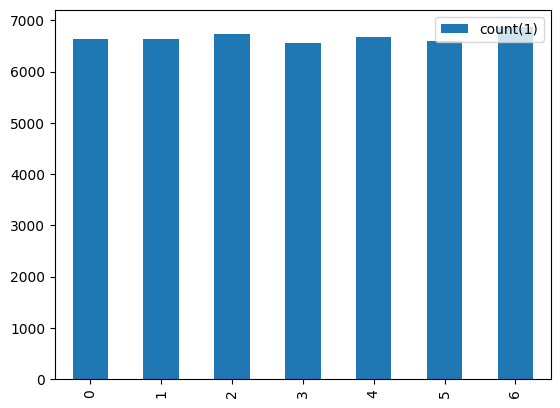

23/02/21 06:14:53 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 907922 ms exceeds timeout 120000 ms
23/02/21 06:14:53 WARN SparkContext: Killing executors is not supported by current scheduler.


In [202]:
pdf.plot(kind='bar')

In [204]:
pdf = spark.sql("Select CUST_STATE, count(*) from customer_tb group by CUST_STATE").toPandas()

In [203]:
customer.printSchema()

root
 |-- SSN: integer (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- FULL_STREET_ADDRESS: string (nullable = true)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_ZIP: integer (nullable = true)
 |-- CUST_PHONE: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- LAST_UPDATED: timestamp (nullable = true)



<AxesSubplot: >

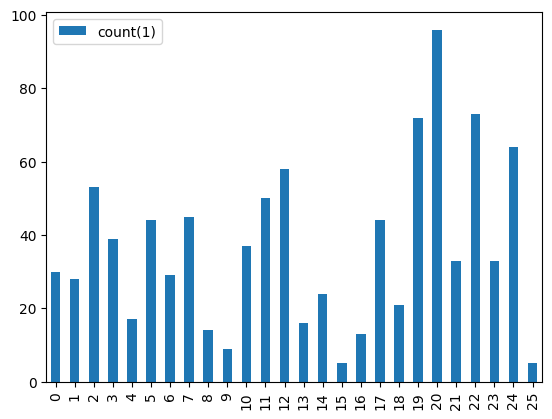

In [205]:
pdf.plot(kind='bar')

In [206]:
credit.printSchema()

root
 |-- CUST_CC_NO: string (nullable = true)
 |-- TIMEID: string (nullable = true)
 |-- CUST_SSN: integer (nullable = true)
 |-- BRANCH_CODE: integer (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- TRANSACTION_ID: integer (nullable = true)



In [13]:
# TODO: CHECK the result!, DASH?
spark.sql("Select  credit_tb.CUST_SSN, customer_tb.FIRST_NAME, customer_tb.LAST_NAME, SUM(credit_tb.TRANSACTION_VALUE) as Spending from credit_tb \
    JOIN customer_tb ON credit_tb.CUST_SSN = customer_tb.SSN group by credit_tb.CUST_SSN,customer_tb.FIRST_NAME, customer_tb.LAST_NAME ORDER BY Spending DESC LIMIT 10;").show()

+---------+----------+----------+------------------+
| CUST_SSN|FIRST_NAME| LAST_NAME|          Spending|
+---------+----------+----------+------------------+
|123451125|        Ty|      Daly|5633.0700000000015|
|123452783|    Jessie|   Boucher| 5548.140000000001|
|123453486|    Phoebe|    Martin| 5476.079999999999|
|123458668|   Thurman|      Vera| 5314.970000000003|
|123456678|      Bret|   Perkins| 5261.030000000001|
|123452026|    Joesph|   Mcclain|           5241.18|
|123452518|   Aurelia|      Haas| 5223.959999999999|
|123454933|   Marcelo|   Emerson| 5203.080000000001|
|123457547|    Alexis|Villarreal|           5149.75|
|123452085| Christina|      Snow| 5133.290000000002|
+---------+----------+----------+------------------+



### Req.5 Data Analysis and Visualization
*   Find and plot the percentage of applications approved for self-employed applicants.

*    Find the percentage of rejection for married male applicants.

*    Find and plot the top three months with the largest transaction data.

*    Find and plot which branch processed the highest total dollar value of healthcare transactions.




In [17]:
## LOAN APPLICATION ANALYSIS:
loan = spark.read \
    .jdbc("jdbc:mysql://localhost:3306/creditcard_capstone","CDW_SAPP_loan_application", \
          properties={"user": "root", "driver":"com.mysql.cj.jdbc.Driver"})
loan.createOrReplaceTempView("loan_tb")
loan.show(3)

+--------------+------+-------+----------+------------+-------------+--------------+-------------+------+------------------+
|Application_ID|Gender|Married|Dependents|   Education|Self_Employed|Credit_History|Property_Area|Income|Application_Status|
+--------------+------+-------+----------+------------+-------------+--------------+-------------+------+------------------+
|      LP001520|  Male|    Yes|         0|    Graduate|           No|             1|    Semiurban|medium|                 Y|
|      LP001744|  Male|     No|         0|    Graduate|           No|             1|    Semiurban|   low|                 Y|
|      LP001245|  Male|    Yes|         2|Not Graduate|          Yes|             1|    Semiurban|   low|                 Y|
+--------------+------+-------+----------+------------+-------------+--------------+-------------+------+------------------+
only showing top 3 rows



In [15]:
loan.printSchema()

root
 |-- Application_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- Application_Status: string (nullable = true)



In [28]:
row_list = loan.select("Self_Employed","Application_Status")\
                .groupBy("Self_Employed","Application_Status").count().collect()
row_list

[Row(Self_Employed='Yes', Application_Status='Y', count=46),
 Row(Self_Employed='No', Application_Status='Y', count=301),
 Row(Self_Employed='Yes', Application_Status='N', count=24),
 Row(Self_Employed='No', Application_Status='N', count=140)]

In [45]:
total = 0
for row  in row_list:
    if (row['Self_Employed']=="Yes"):
        total += row['count']
        if (row['Application_Status']=='Y'):
            approved = row['count']
print(round(approved/total,2))

0.66


In [54]:
row_list = loan.select("Self_Employed","Application_Status")\
                .groupBy("Self_Employed","Application_Status").count().toPandas()
row_list

,Self_Employed,Application_Status,count
0,Yes,Y,46
1,No,Y,301
2,Yes,N,24
3,No,N,140


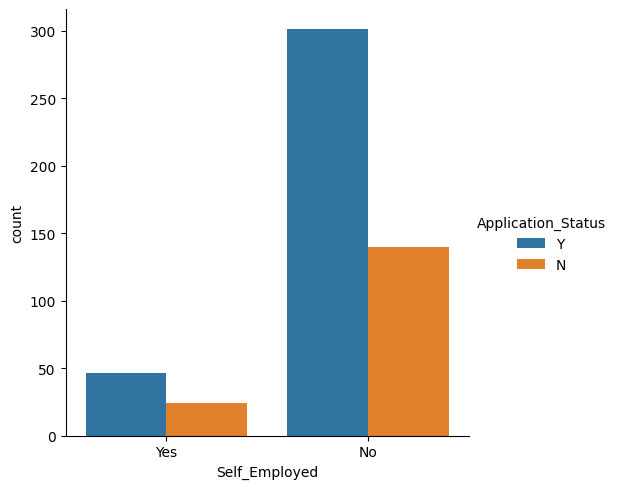

In [56]:
sns.catplot(data=row_list, x='Self_Employed', y="count", hue="Application_Status", kind="bar")

In [57]:
row_list = loan.select("Married", "Gender", "Application_Status")\
                .groupBy("Married","Gender", "Application_Status").count().collect()
row_list

[Row(Married='No', Gender='Female', Application_Status='Y', count=40),
 Row(Married='Yes', Gender='Male', Application_Status='Y', count=219),
 Row(Married='Yes', Gender='Male', Application_Status='N', count=87),
 Row(Married='Yes', Gender='Female', Application_Status='Y', count=17),
 Row(Married='No', Gender='Female', Application_Status='N', count=26),
 Row(Married='No', Gender='Male', Application_Status='N', count=43),
 Row(Married='Yes', Gender='Female', Application_Status='N', count=8),
 Row(Married='No', Gender='Male', Application_Status='Y', count=71)]

In [58]:
df_p = loan.select("Married", "Gender", "Application_Status")\
                .groupBy("Married","Gender", "Application_Status").count().toPandas()
df_p

,Married,Gender,Application_Status,count
0,No,Female,Y,40
1,Yes,Male,Y,219
2,Yes,Male,N,87
3,Yes,Female,Y,17
4,No,Female,N,26
5,No,Male,N,43
6,Yes,Female,N,8
7,No,Male,Y,71


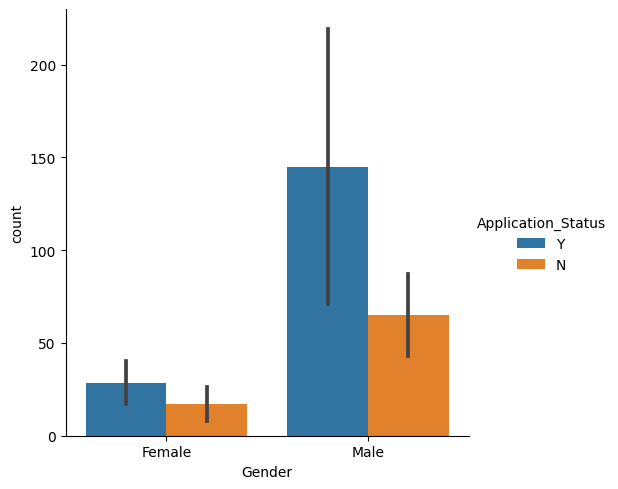

In [60]:
sns.catplot(data=df_p[["Gender","Application_Status","count"]], x="Gender", y="count", hue="Application_Status", kind="bar")

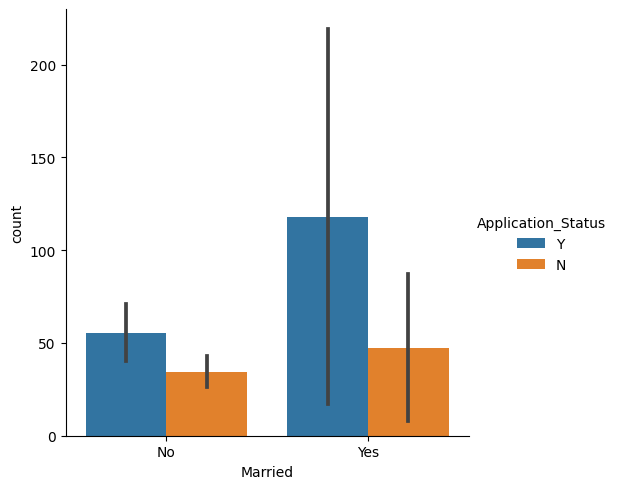

In [61]:
sns.catplot(data=df_p[["Married","Application_Status","count"]], x="Married", y="count", hue="Application_Status", kind="bar")

In [50]:
approved = loan.select("Married", "Gender", "Application_Status")\
                .filter(loan["Married"]=='Yes')\
                .filter(loan["Gender"]=='Male')\
                .filter(loan["Application_Status"]=='Y')\
                .groupBy("Married","Gender", "Application_Status").count().collect()
rejected = loan.select("Married", "Gender", "Application_Status")\
                .filter(loan["Married"]=='Yes')\
                .filter(loan["Gender"]=='Male')\
                .filter(loan["Application_Status"]=='N')\
                .groupBy("Married","Gender", "Application_Status").count().collect()
approved, rejected

([Row(Married='Yes', Gender='Male', Application_Status='Y', count=219)],
 [Row(Married='Yes', Gender='Male', Application_Status='N', count=87)])

In [51]:
rejected[0]['count']/(approved[0]['count']+rejected[0]['count'])

0.28431372549019607